Filename: C:\Users\Reethika Prasanna\Downloads\hlsp_orion_hst_acs_strip2r_f775w_v1_drz_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     651   ()      
  1  SCI           1 ImageHDU       141   (18000, 7500)   float32   
0.1722082 0.0 0.204264
 id  xcenter   ycenter  aperture_sum total_bkg
       pix       pix                          
--- --------- --------- ------------ ---------
  1 2126.1705 332.52299    2167.2949 558.21089
  2  2146.497 334.54051    11123.411 1045.9774
  3   2146.48 335.22234    11213.717 1051.2014
  4 1988.3921 449.16744    119.60002 25.757722
  5 3841.2778 499.22172    107.57758 35.034182
  6 3173.9223 560.46514    345.44209 31.953649
  7 2134.1283 575.75726    90.214546 28.313748
  8 3047.5161  611.0992    409.59362 32.993272
  9 2320.2371 839.65208    160.12934 28.301394
 10 5083.8965 899.86208    1678.8108  39.15708
 11 3843.9126 926.50592    4509.6619 58.377525
 12 5518.8208 993.29439    2929.2296 48.4

Please enter the instrument/detector value manually (e.g., WFC):  WFC


Please enter the observation date manually (YYYY-MM-DD):  2004-10-30


Please enter the filter name manually (e.g., F775W):  F775W


Please enter the exposure time manually (in seconds):  2695


Filter PHOTLAM             PHOTFLAM            STmag  VEGAmag  ABmag 
       Angstrom erg / (Angstrom electron cm2) mag(ST)   mag   mag(AB)
------ -------- ----------------------------- ------- ------- -------
 F775W   7693.9                    9.9243e-20  26.408  25.272   25.67


Please enter the zeropoint manually (viewing AB mag):  25.67


Error: Zeropoint is not a valid numeric value: None


Please enter a valid zeropoint value (numeric):  25.67


Error: Invalid exposure time: 25.67


Please enter a valid exposure time (numeric):  2695


Using exposure time: 2695.0 seconds


 id  xcenter   ycenter  aperture_sum total_bkg     magnitude      luminosity_relative_to_sun        fwhm       
       pix       pix                                                                                           
--- --------- --------- ------------ --------- ------------------ -------------------------- ------------------
  1 2126.1705 332.52299    2167.2949 558.21089 17.330308741438976      9.997156790528724e-06  5.481861338572078
  2  2146.497 334.54051    11123.411 1045.9774 15.554442904397563      5.131246027485228e-05  8.948642551686905
  3   2146.48 335.22234    11213.717 1051.2014  15.54566382016671      5.172904633562962e-05  8.865558928467758
  4 1988.3921 449.16744    119.60002 25.757722 20.475758637699286      5.516918203182939e-07 1.3687190784106371
  5 3841.2778 499.22172    107.57758 35.034182 20.590826736528918      4.962143339221996e-07 1.3362474551638859
  6 3173.9223 560.46514    345.44209 31.953649  19.32409913343656     1.5935303766660344e-06 2.526589867

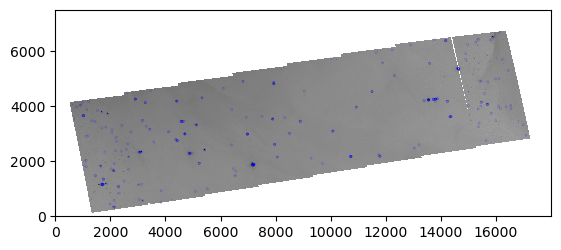

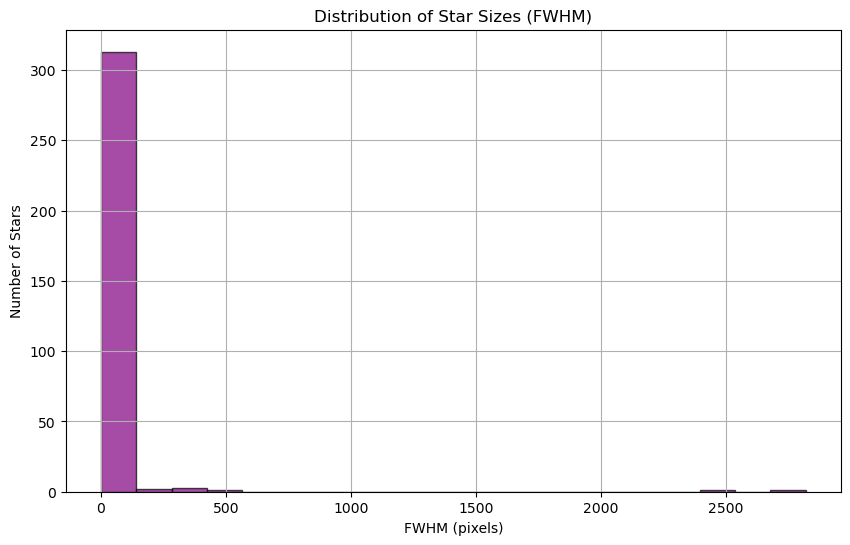

Star data saved successfully to 'star_data.csv'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import cv2
from acstools import acszpt
from matplotlib.colors import LogNorm
file_path=r"C:\Users\Reethika Prasanna\Downloads\hlsp_orion_hst_acs_strip2r_f775w_v1_drz_sci.fits"


hdul=fits.open(file_path)
hdul.info()

header = hdul[1].header
section_1=hdul[1].data

from astropy.stats import sigma_clipped_stats
mean,median,std=sigma_clipped_stats(section_1, sigma=3.0)
print((mean),(median),(std))

from photutils.detection import DAOStarFinder
daofind=DAOStarFinder(fwhm=3.0,threshold=100.0*std)
sources=daofind(section_1-median)

for col in sources.colnames:
    if col not in('id','npix'):
        sources[col].info.format='%.2f'

from photutils.aperture import CircularAperture
positions=np.transpose((sources['xcentroid'],sources['ycentroid']))
apertures=CircularAperture(positions,r=5.0)
plt.imshow(section_1,cmap='Greys',origin='lower',norm=LogNorm(),interpolation='nearest')
apertures.plot(color='blue',lw=1.5,alpha=0.5);


from photutils.aperture import CircularAnnulus,ApertureStats,aperture_photometry
annulus_aperture=CircularAnnulus(positions,r_in=10,r_out=15)




aperstats=ApertureStats(section_1,annulus_aperture)
bkg_mean=aperstats.mean
aperture_area=apertures.area_overlap(section_1)
total_bkg=bkg_mean*aperture_area
star_data=aperture_photometry(section_1,apertures)
star_data['total_bkg']=total_bkg
for col in star_data.colnames:
    star_data[col].info.format='%.8g'
star_data.pprint()

date = header.get('DATE-OBS')  # Observation date
instrument = header.get('INSTRUME')  # Instrument name
filter_name = header.get('FILTER')  # Filter name
extime = header.get('EXPTIME')  # Exposure time (in seconds)
zeropoint=header.get('ZPT')
if instrument is None:
    print("WARNING: 'DETECTOR' information is missing in the FITS header.")
    instrument = input("Please enter the instrument/detector value manually (e.g., WFC): ").strip().upper()
# Check if the date is missing
if date is None:
    print("WARNING: 'DATE-OBS' information is missing in the FITS header.")
    date = input("Please enter the observation date manually (YYYY-MM-DD): ").strip()

if filter_name is None:
    print("WARNING: 'FILTER' information is missing in the FITS header.")
    filter_name = input("Please enter the filter name manually (e.g., F775W): ").strip().upper()
if extime is None:
    print("WARNING: 'EXPTIME' information is missing in the FITS header.")
    extime = input("Please enter the exposure time manually (in seconds): ").strip()

q=acszpt.Query(date=date,detector=instrument)
zpt_table=q.fetch()
q_filter=acszpt.Query(date=date,detector=instrument,filt=filter_name)
filter_zpt=q_filter.fetch()
print(filter_zpt)
# Check if zeropoint is available from the data
if zeropoint is None:
    print("WARNING: 'zeropoint' information is missing in the FITS header.")
    extime = input("Please enter the zeropoint manually (viewing AB mag): ").strip()
import math

# Make sure zeropoint is numeric
if not isinstance(zeropoint, (int, float)):
    print(f"Error: Zeropoint is not a valid numeric value: {zeropoint}")
    zeropoint = float(input("Please enter a valid zeropoint value (numeric): "))  # Get user input if invalid

# Ensure extime is numeric and not zero
if not isinstance(extime, (int, float)) or extime == 0:
    print(f"Error: Invalid exposure time: {extime}")
    extime = float(input("Please enter a valid exposure time (numeric): "))  # Get user input if invalid

# Ensure valid extime input
print(f"Using exposure time: {extime} seconds")

magnitudes = []
for line in star_data:
    flux = line[3]  # Assuming this is the flux value
    background = line[4]  # Assuming this is the background value
    
    # Ensure flux and background are valid numeric values
    if isinstance(flux, (int, float)) and isinstance(background, (int, float)):
        denominator = background / extime  # background divided by exposure time
        try:
            magnitude = zeropoint - (2.5 * math.log10(abs(flux - denominator)))
            magnitudes.append(magnitude)
        except ValueError:
            print(f"Invalid flux or background data for line: {line}. Skipping.")
            magnitudes.append(float('nan'))  # Skip this entry if error occurs
    else:
        print(f"Invalid data types for flux or background in line: {line}")
        magnitudes.append(float('nan'))  # Handle invalid data
    
# Store calculated magnitudes in star_data
star_data['magnitude'] = magnitudes


M_sun = 4.83  # Absolute magnitude of the Sun

# Calculate luminosity relative to the Sun
luminosities_relative_to_sun = []
for mag in magnitudes:
    relative_luminosity = 10 ** ((M_sun - mag) / 2.5)  # Luminosity ratio
    luminosities_relative_to_sun.append(relative_luminosity)

# Add the relative luminosity to the star data table
star_data['luminosity_relative_to_sun'] = luminosities_relative_to_sun

from astropy.modeling import models, fitting
import numpy as np

# Prepare a list to store the calculated FWHM values
fwhm_values = []

# Iterate through each detected star in the sources table
for i, source in enumerate(sources):
    x = source['xcentroid']
    y = source['ycentroid']
    
    # Define a small cutout region around the star's centroid
    cutout_size = 10  # Size of the cutout region (adjust as needed)
    x_min, x_max = int(x - cutout_size // 2), int(x + cutout_size // 2)
    y_min, y_max = int(y - cutout_size // 2), int(y + cutout_size // 2)
    
    # Extract the cutout data
    cutout = section_1[y_min:y_max, x_min:x_max]
    
    # Skip if the cutout is outside the bounds of the image
    if cutout.shape[0] < cutout_size or cutout.shape[1] < cutout_size:
        fwhm_values.append(float('nan'))  # Append NaN for invalid cutouts
        continue

    # Create a grid of coordinates for the cutout
    y_coords, x_coords = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
    
    # Define an initial 2D Gaussian model
    gaussian_init = models.Gaussian2D(
        amplitude=cutout.max(),
        x_mean=cutout_size // 2,
        y_mean=cutout_size // 2,
        x_stddev=1.0,
        y_stddev=1.0
    )
    
    # Fit the Gaussian model to the cutout data
    fitter = fitting.LevMarLSQFitter()
    gaussian_fit = fitter(gaussian_init, x_coords, y_coords, cutout)
    
    # Calculate FWHM in x and y directions
    fwhm_x = 2.3548 * gaussian_fit.x_stddev.value
    fwhm_y = 2.3548 * gaussian_fit.y_stddev.value
    
    # Store the average FWHM for the star
    fwhm_values.append((fwhm_x + fwhm_y) / 2.0)

# Add the FWHM values to the sources table
star_data['fwhm'] = fwhm_values

# Print the updated sources table with FWHM values
for col in sources.colnames:
    sources[col].info.format = '%.3f'  # Format columns for better readability
star_data.pprint(max_lines=-1, max_width=-1)

# Plot the distribution of FWHM values
plt.figure(figsize=(10, 6))
plt.hist(fwhm_values, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('FWHM (pixels)')
plt.ylabel('Number of Stars')
plt.title('Distribution of Star Sizes (FWHM)')
plt.grid(True)
plt.show()

from astropy.table import Table
star_data_table = Table(star_data)

# Save the table as a CSV file
output_csv_file = "star_data.csv"
star_data_table.write(output_csv_file, format='csv', overwrite=True)

print(f"Star data saved successfully to '{output_csv_file}'")